This is a continuation of the experiment done on the gymnasium cart pole example in the classic-control environment package. Different from the cart pole environment, the inverted pendulum environment in the MuJoCo package extends to continuous action space. Therefore, the output of policy approximation is no longer the probability of each action


## Library imports

In [4]:
import gymnasium as gym
import torch
from torch import nn
import torch.optim as optim
from torch.distributions import Normal      # normal dist

import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

import re
import os
import json
import time
from datetime import datetime

# Explore the Environment

In [ ]:
env = gym.make("InvertedPendulum-v5",render_mode='human')
obs_space = env.observation_space.shape[0]
act_space = env.action_space.shape[0]
print(f"This environment has {obs_space} continuous state observations "
      f"and {act_space} continuous action")

# Simulate several episodes
for i in range(1):
    obs, _ = env.reset()
    t = 1
    done = False
    while not done:
        random_action = env.action_space.sample()
        
        next_obs, reward, term, trunc, _ = env.step(random_action)
        print(f"Time {t:2d}  |  s_t {obs}  |  a_t {random_action}  |  reward {reward} |  s_t+1 {next_obs}")
        obs = next_obs; t += 1
        done = term or trunc

env.close()

# Simplified PPO

## Parameter and Class Definition

In [ ]:
# Hyperparameter definitions
MODEL_NAME = 'PPO_MLP_v0'
ALPHA = 1e-4
BETA = 1e-4
GAMMA = 0.99                    # discount factor for return calculation
EPS = 0.1

BUFFER_SIZE = 2048
BATCH_SIZE = 64

N_ITERATION = 100            # number of episodes to train the Q-network
N_EPOCH = 10
N_EPISODE_TEST = 5
CUDA_ENABLED = False
SUCCESS_CRITERIA = 900

In [6]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64,64], cuda_enabled=False):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim        # (action_space,) to estimate mean of the Gaussian action distribution in a state
        # hidden layers
        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size
        # output layers
        self.layers.append(nn.Linear(input_dim, self.output_dim))

        # Trainable log_std (one per action dim)
        log_std = -0.5 * torch.ones(output_dim, dtype=torch.float32, device='cuda' if cuda_enabled else 'cpu')
        self.log_std = nn.Parameter(log_std)

        if cuda_enabled: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        mu = self.layers[-1](input)
        std = torch.exp(self.log_std)
        return mu, std
    
class ValueNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[32,32], cuda_enabled=False):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size

        self.layers.append(nn.Linear(input_dim, self.output_dim))
        if cuda_enabled: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        output = self.layers[-1](input)
        return output

In [7]:
model_registry = {
    'PPO_MLP_v0': {
        'class': PolicyNet,
        'config': [64,32],
        'value_class': ValueNet,
        'value_config': [32]
    }
}

In [8]:
class PPOBuffer():
    def __init__(self, obs_dim, act_dim, buffer_size):
        self.obs_buf = np.zeros((buffer_size, obs_dim), dtype = np.float32)
        self.act_buf = np.zeros(buffer_size, dtype = np.float32)
        self.rew_buf = np.zeros(buffer_size, dtype = np.float32)
        self.nobs_buf = np.zeros((buffer_size, obs_dim), dtype = np.float32)    # Next observation
        self.logp_buf = np.zeros(buffer_size, dtype = np.float32)               # pi(a_t|s_t) or the prob of the current action given the current observation           
        self.done_buf = np.zeros(buffer_size, dtype = np.bool_)

        self.val_buf = np.zeros(buffer_size, dtype = np.float32)                # Estimated state value of current obs
        self.adv_buf = np.zeros(buffer_size, dtype = np.float32)
        self.tar_buf = np.zeros(buffer_size, dtype = np.float32)                # Buffer of critic target

        self.ptr = 0
        self.buffer_size = buffer_size

    def store(self, obs, act, rew, next_obs, logp, done):            # Store the transitions
        assert self.ptr < self.buffer_size
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.nobs_buf[self.ptr] = next_obs
        self.logp_buf[self.ptr] = logp
        self.done_buf[self.ptr] = done
        self.ptr += 1

    def get_transition(self):
        ''' Get the data to calculate state value and critic target before training'''
        data = dict(obs=self.obs_buf,
                    act=self.act_buf,
                    rew=self.rew_buf,
                    next_obs = self.nobs_buf,
                    logp=self.logp_buf,
                    done=self.done_buf)
        
        return data
        
    def get_data(self):
        data = dict(obs=self.obs_buf, act=self.act_buf,
                    rew=self.rew_buf, next_obs = self.nobs_buf,
                    logp=self.logp_buf, done=self.done_buf,
                    val=self.val_buf,
                    adv=self.adv_buf,
                    tar=self.tar_buf)
        return data

In [57]:
class PPO():
    def __init__(self, model_name: str,
                 model_registry,
                 alpha: float, beta: float, gamma: float,
                 eps: float,
                 buffer_size: int, batch_size: int,
                 n_iter_train = 5000, n_epoch = 10,
                 result_folder = 'invpend_PPO_results',
                 seed = 42,
                 cuda_enabled = False,
                 verbose = True):
        
        self.result_folder = result_folder
        self.SEED = seed
        self.CUDA_ENABLED = cuda_enabled
        self.VERBOSE = verbose
        self.LOG_PERIOD = 1

        self.alpha, self.beta, self.gamma = alpha, beta, gamma
        self.eps = eps
        self.buffer_size, self.batch_size = buffer_size, batch_size
        self.N_ITER_TRAIN = n_iter_train
        self.N_EPOCH = n_epoch

        # Initialize the train and validation environments
        self.env = gym.make("InvertedPendulum-v5", render_mode="rgb_array")
        self.env_val = gym.make("InvertedPendulum-v5", render_mode="rgb_array")
        self.obs_space = self.env.observation_space.shape[0]
        self.act_space = self.env.action_space.shape[0]
        
        ''' Experiment hyperparameters '''  
        # Policy model configuration
        self.model_name = model_name
        match = re.search(r'v\d+', self.model_name)
        self.model_id = match.group(0) if match else 404

        self.policy_model_class = model_registry[self.model_name]['class']
        self.policy_model_config = model_registry[self.model_name]['config']
        self.value_model_class = model_registry[self.model_name]['value_class']
        self.value_model_config = model_registry[self.model_name]['value_config']

        # Instantiate and initialize the policy network
        self.policy_net = self.policy_model_class(self.obs_space, self.act_space, self.policy_model_config)
        self.policy_net.apply(self.init_weights)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.alpha)

        self.policy_net_old = self.policy_model_class(self.obs_space, self.act_space, self.policy_model_config)
        self.policy_net_old.load_state_dict(self.policy_net.state_dict())
        self.policy_net_old.eval()                              # Set to only do inference
        
        # Instantiate and initialize the state value network
        self.value_net = self.value_model_class(self.obs_space, 1, self.value_model_config)
        self.value_net.apply(self.init_weights)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr = self.beta)

        self.save_path = ''
        self.model_path = ''
        self.hyperparam_config = ''
        self.reward_history = []
        self.val_history = {}                                           # Monitor which episode had a validation run, the train reward, and the validation (test) reward 

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def create_directory(self):
        ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

        Parameters: 
        ------------
        (hyperparameters for differentiating between different directory)
        
        lr : float
            the learning rate to optimize the Q network
        gamma : float 
            the discount rate in Q learning
        
        Returns
        ------------
        name_codified : str
            the shortened name for the current experiment 
        hyperparameters_codified : str
            the shortened string of hyperparameter configuration
        OUTPUT_DIR : path
            the directory to which the training results and model (state_dict and architecture) will be saved
        '''
        timestamp = datetime.now().strftime("%y%m%d_%H%M")

        RESULT_FOLDER = self.result_folder
        BASE_DIR = os.getcwd()
        RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
        os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

        # Find the trial # of the latest run
        existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
        run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
        trial_number = max(run_numbers,default=-1)+1

        # Create a folder for the run
        name_codified = f"run_{trial_number:05d}"
        OUTPUT_DIR = os.path.join(RESULT_DIR,name_codified)
        os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

        # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
        trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
        if os.path.exists(trial_to_param_path):
            with open(trial_to_param_path, "r") as f:
                data = json.load(f)
        else:
            data = {name_codified: ""}

        hyperparam_codified = "PPO_"
        hyperparam_codified += "OOP_"
        hyperparam_codified += "CUDA_" if self.CUDA_ENABLED else "nCUDA_"
        hyperparam_codified += f"{self.model_id}_{self.alpha}_{self.beta}_{self.gamma}"
        hyperparam_codified_time = f"{timestamp}_" + hyperparam_codified

        data[name_codified] = hyperparam_codified_time

        with open(trial_to_param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Store the training configs in JSON file
        training_params = {
            'OOP':                  True,
            'CUDA':                 self.CUDA_ENABLED,
            'device':               torch.cuda.get_device_name(torch.cuda.current_device()),
            'model_name':           self.model_name,
            'alpha':                self.alpha,
            'beta':                 self.beta,
            'gamma':                self.gamma,
            'eps':                  self.eps,
            'buffer_size':          self.buffer_size,
            'batch_size':           self.batch_size,
            'epoch':                self.N_EPOCH
        }

        # Store training parameters in each run 
        param_path = os.path.join(OUTPUT_DIR, "param_config.json")
        with open(param_path, "w") as f:
            json.dump({"parameters": training_params}, f, indent=2)

        return name_codified, hyperparam_codified, OUTPUT_DIR
    
    def get_first_return(self, eps_reward_history):
        ''' Function to calculate the return of the first state '''
        gamma = self.gamma
        
        return_val = [gamma ** i * eps_reward_history[i] for i in range(len(eps_reward_history))]
        return sum(return_val)

    def policy_eval(self, env: gym.Env, n_iter_test = 500, verbose = True):
        ''' Assess the average reward when following the policy net in a test environment with random state initialization
        
        Parameters:
        ----------
        env : gymnasium environment
            this environment can be either the self.env_test or self.env_val environment (whether they are the same)
        n_episode_test : int 
            the number of evaluation episodes
        verbose : bool
            whether to print testing information 

        Return:
        ----------
        average_reward : float
            the average reward received from running the test
        '''

        reward_history = []
        with torch.no_grad():
            for i in range(n_iter_test):
                obs,_ = env.reset()
                done = False
                eps_reward = 0

                while not done:                 # Step thorugh the episode deterministically (no exploration)
                    obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
                    action_mu, action_std = self.policy_net(obs_tensor)
                    action_dist = Normal(action_mu, action_std)
                    action = action_dist.sample()
                    next_obs, reward, term, trunc, _ = env.step(action)

                    # Strategy 1 - Accumulate the reward from the environment
                    eps_reward += reward

                    # TODO - Strategy 2 - evaluate the strategy based on states

                    obs = next_obs
                    done = term or trunc
            
                reward_history.append(eps_reward)
                if verbose:
                    print(f"Validation episode {i+1:3d}/{n_iter_test}  |   Reward = {eps_reward:4.0f}",end="\r")
        reward_mean = mean(reward_history)
        reward_stdev = stdev(reward_history)
        
        return reward_mean, reward_stdev
    
    def EMA_filter(self, reward: list, alpha):
        ''' Function that runs an exponential moving average filter along a datastream '''
        output = np.zeros(len(reward)+1)
        output[0] = reward[0]
        for idx, item in enumerate(reward):
            output[idx+1] = (1 - alpha) * output[idx] + alpha * item
        
        return output
    
    def plot_reward_hist(self, alpha = 0.1):
        ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
        n_episodes= len(self.reward_history)
        episodes = range(n_episodes)
        filtered_reward_hist = self.EMA_filter(self.reward_history, alpha)
        fig, axes = plt.subplots(1,1, figsize=(20,6))

        axes.plot(episodes, self.reward_history[:n_episodes], label = 'Total reward', color = "blue")
        axes.plot(episodes, filtered_reward_hist[:n_episodes], label = 'Filtered reward', color = "red")
        axes.set_title(f'Total reward per episode - {self.hyperparam_config}')
        axes.set_xlabel('Episode')
        axes.set_ylabel('Reward')
        axes.legend()
        
        # axes[0].plot(episodes, self.reward_history[:n_episodes], label = 'Total reward', color = "blue")
        # axes[0].plot(episodes, filtered_reward_hist[:n_episodes], label = 'Filtered reward', color = "red")
        # axes[0].set_title(f'Total reward per episode - {self.hyperparam_config}')
        # axes[0].set_xlabel('Episode')
        # axes[0].set_ylabel('Reward')
        # axes[0].legend()

        # n_episodes= len(self.value_history)
        # episodes = range(n_episodes)
        # axes[1].plot(episodes, self.value_history[:n_episodes], label = "v(s_0)", color = "blue")
        # # If using baseline with a value estimation model, plot this as well
        # axes[1].plot(episodes, self.value_est_history[:n_episodes], label = r"$\hat v$(s_0)", color = "red")
        # axes[1].set_title(f'Return in state s_0 - {self.hyperparam_config}')
        # axes[1].set_xlabel('Episode')
        # axes[1].set_ylabel('v(s_0)')
        # axes[1].legend()

        plt.tight_layout()
        if self.save_path:
            plt.savefig(os.path.join(self.save_path,'reward_history.png'))
        plt.show()

    def save_model(self):
        ''' Function to save the model and optimizer state_dict for inference or continued training '''
        self.model_path = os.path.join(self.save_path, 'q_network_checkpoint.pth')
        torch.save({
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, self.model_path)

    def load_model(self):
        ''' This code overwrite the Q_net with the parameters store in the instance's save_path '''
        checkpoint = torch.load(self.model_path)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])

    def prefill_buffer(self):
        ''' Function that prefill a buffer with transitions (s,a,r,s',d) under the current policy '''
        self.buffer = PPOBuffer(self.obs_space, self.act_space, self.buffer_size)
        
        buffer_filled = False
        count = 0
        eps_return = []     # Store v(s_0) of each episode in the buffer
        eps_length = []
        # Collect experience using the old (frozen) policy
        while not buffer_filled:
            obs, _ = self.env.reset()
            done = False
            eps_reward_history = []
            
            while not done:
                with torch.no_grad():
                    obs_tensor = torch.tensor(obs, dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')
                    action_mu, action_std = self.policy_net_old(obs_tensor)
                    action_dist = Normal(action_mu, action_std)
                    action = action_dist.sample()
                    action_logp = action_dist.log_prob(action).sum(-1).item()
                next_obs, reward, term, trunc, _ = self.env.step(action) 
                eps_reward_history.append(reward)
                done = term or trunc

                self.buffer.store(obs_tensor, action.item(), reward, next_obs, action_logp, done)
                obs = next_obs

                count += 1

                if count >= self.buffer_size: 
                    buffer_filled = True
                    break
            
            # Only account for full episodes (exclude the last one that is terminated due to buffer size)
            if not buffer_filled: 
                eps_length.append(len(eps_reward_history))
                eps_return.append(self.get_first_return(eps_reward_history))

        # Average value V(s_0) and average episode length 
        self.avg_return = np.mean(eps_return)
        self.avg_length = np.mean(eps_length)

        # Calculate the estimated state value, critic target, and advantage
        data = self.buffer.get_transition()
        obs_tensor = torch.tensor(data['obs'], dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')
        rew_tensor = torch.tensor(data['rew'], dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu').unsqueeze(dim=1)
        nobs_tensor = torch.tensor(data['next_obs'], dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')
        done_tensor = torch.tensor(data['done'], dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu').unsqueeze(dim=1)

        with torch.no_grad():
            val_tensor = self.value_net(obs_tensor)
            next_val_tensor = self.value_net(nobs_tensor)
        tar_tensor = rew_tensor + self.gamma * (1-done_tensor) * next_val_tensor
        adv_tensor = tar_tensor - val_tensor

        ## TODO - See if normalizing the advantage improvement training
        adv_tensor = (adv_tensor - adv_tensor.mean()) / (adv_tensor.std() + 1e-8)

        self.buffer.val_buf = val_tensor.cpu().numpy().squeeze()
        self.buffer.tar_buf = tar_tensor.cpu().numpy().squeeze()
        self.buffer.adv_buf = adv_tensor.cpu().numpy().squeeze() 

    def train_policy(self):
        msg = "Training ended with no good model found :<"

        # # Create the directory to store results
        # self.run_number, self.hyperparam_config, self.save_path = self.create_directory()

        # Training information
        title = f"PPO   |   Model {self.model_name}, alpha={self.alpha}, beta={self.beta}, gamma={self.gamma}" 
        if self.VERBOSE: print(title)

        self.reward_history = []                # Track the total reward per episode
        self.val_history = {}                   # Reset the validation history
        self.value_history = []                 # History of the v(s_0) calculated using G_t throughout training
        self.value_est_history = []             # History of the \hat v(s_0) calculated using the value net (baseline case)
        self.val_time = 0                       # Time used for validation (s)

        # Control of early stopping
        consecutive_pass_count = 0
        CONSECUTIVE_PASS_LIMIT = 3
        EPISODE_REWARD_LIMIT = SUCCESS_CRITERIA
        best_reward = 0
        self.best_model_episode = None
        performance_crit = False                # Whether desired performance is met consistently
        train_terminated = False
        

        self.train_time_start = time.time()
        
        # while not train_terminated:             # Experiment level - iterate over training episodes
        for iter in range(self.N_ITER_TRAIN):
            self.policy_net_old.load_state_dict(self.policy_net.state_dict())
            self.prefill_buffer()               # Generate the training data using the old policy

            self.reward_history.append(self.avg_length)

            # Periodic data logger
            if iter % self.LOG_PERIOD == 0 and self.VERBOSE:
                printout_msg = f"Iteration {iter:3d} : Mean V(s_0) {self.avg_return:7.2f} | Mean Length {self.avg_length:7.2f}"
                print(printout_msg, end='\r')

            # Early stopping condition
            if self.avg_length >= EPISODE_REWARD_LIMIT:
                # Evaluate the current good policy and record the validation time
                self.val_time_start = time.time()
                test_reward, _ = self.policy_eval(self.env_val, 20, verbose=False)
                self.val_time += time.time() - self.val_time_start

                self.val_history[iter] = [self.avg_length, test_reward]

                if test_reward >= best_reward:           # Set the new best reward
                    best_reward = test_reward
                    self.save_model()
                    self.best_model_iteration = iter
                    msg = f"Training terminated due to iteration limit, best model saved at episode {self.best_model_iteration:5d}"
                if test_reward > EPISODE_REWARD_LIMIT: 
                    consecutive_pass_count += 1
                else: consecutive_pass_count = 0
            else:
                consecutive_pass_count = 0

            # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
            if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
                self.save_model()
                self.best_model_iteration = iter
                performance_crit = True 
                msg = f"Early termination at iteration {self.best_model_iteration:5d}, desired performance reached"

            # Checking for early training termination or truncation
            train_terminated = performance_crit
            if train_terminated:
                break
            
            # Loop through epochs
            for epoch in range(self.N_EPOCH):       # Iterate over multiple epochs of training data
                indices = np.arange(self.buffer_size)
                np.random.shuffle(indices)

                # Iterate over mini batches
                for start in range(0, self.buffer_size, self.batch_size):
                    end = start + self.batch_size
                    batch_idx = indices[start:end]
                    
                    batch_data = self.buffer.get_data()
                    obs_batch = torch.tensor(batch_data['obs'][batch_idx], dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')
                    act_batch = torch.tensor(batch_data['act'][batch_idx], dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu').unsqueeze(-1)
                    logp_old = torch.tensor(batch_data['logp'][batch_idx], dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')
                    
                    adv_batch = torch.tensor(batch_data['adv'][batch_idx], dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')
                    tar_batch = torch.tensor(batch_data['tar'][batch_idx], dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu').unsqueeze(dim=1)

                    action_mu, action_std = self.policy_net(obs_batch)
                    action_dist = Normal(action_mu, action_std)
                    logp = action_dist.log_prob(act_batch).squeeze()
                    # print(obs_batch.shape, act_batch.shape, logp_old.shape, logp.shape)

                    ratios = torch.exp(logp - logp_old)
                    # print(ratios)
                    clip_ratios = torch.clamp(ratios, 1 - self.eps, 1 + self.eps)
                    actor_loss = -torch.mean(torch.min(ratios * adv_batch, clip_ratios * adv_batch))

                    self.optimizer.zero_grad()
                    actor_loss.backward()
                    self.optimizer.step()

                    # Optimize the critic network
                    val_tensor = self.value_net(obs_batch)
                    critic_loss = nn.MSELoss()(tar_batch, val_tensor)
                    self.value_optimizer.zero_grad()
                    critic_loss.backward()
                    self.value_optimizer.step()

        self.train_time = time.time() - self.train_time_start

        print(f"\nTotal runtime - {self.train_time:5.2f}")
        print(msg)
        return

    def record(self):
        # Load the best policy net parameter from the experiment
        if self.model_path:
            self.load_model()

        # Average test reward of the resulting policy - if best policy does not exists use the last one
        self.env_test = gym.make('InvertedPendulum-v5')
        print('Testing the best policy network performance')
        reward_mean, reward_stdev = self.policy_eval(self.env_test, n_iter_test=500, verbose=True)
        print(f"\nValidation average reward {reward_mean:4.2f} (SD = {reward_stdev:4.2f})")

        # Store the validation history and average test reward in the param_config JSON file
        param_path = os.path.join(self.save_path, 'param_config.json')
        if os.path.exists(param_path):
            with open(param_path, "r") as f:
                data = json.load(f)
        else:
            data = {}

        data['runtime'] = self.train_time                   if hasattr(self,'train_time') else None
        data['valtime'] = self.val_time                     if hasattr(self,'val_time') else None
        data['best_model_at'] = self.best_model_iteration   if hasattr(self,'best_model_iteration') else None
        data['val_history'] = self.val_history              if hasattr(self,'val_history') else None
        data['test_result'] = [reward_mean, reward_stdev]

        with open(param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Plot
        self.plot_reward_hist()

In [59]:
PPO_experiment = PPO(MODEL_NAME, model_registry,
                     ALPHA, BETA, GAMMA, EPS,
                     BUFFER_SIZE, BATCH_SIZE, 
                     N_ITERATION, N_EPOCH)
PPO_experiment.prefill_buffer()


In [58]:
buffer_data = PPO_experiment.buffer.get_data()
print(buffer_data)

{'obs': array([[ 0.00219793,  0.00618065, -0.00535993,  0.00059014],
       [ 0.0060246 , -0.00298769,  0.19616292, -0.4544399 ],
       [ 0.00686524, -0.00456032, -0.15283304,  0.36400378],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32), 'act': array([ 0.6101117 , -1.0432692 , -0.85012084, ...,  0.        ,
        0.        ,  0.        ], dtype=float32), 'rew': array([1., 1., 1., ..., 0., 0., 0.], dtype=float32), 'next_obs': array([[ 0.0060246 , -0.00298769,  0.19616292, -0.4544399 ],
       [ 0.00686524, -0.00456032, -0.15283304,  0.36400378],
       [-0.00484118,  0.02250733, -0.4320164 ,  0.9859326 ],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32

## PPO Training

In [60]:
PPO_experiment = PPO(MODEL_NAME, model_registry,
                     ALPHA, BETA, GAMMA, EPS,
                     BUFFER_SIZE, BATCH_SIZE, 
                     N_ITERATION, N_EPOCH)

PPO_experiment.train_policy()


PPO   |   Model PPO_MLP_v0, alpha=0.0001, beta=0.0001, gamma=0.99
Iteration  86 : Mean V(s_0)   99.99 | Mean Length  971.50
Total runtime - 182.55
Early termination at iteration    86, desired performance reached


Testing the best policy network performance
Validation episode 500/500  |   Reward = 1000
Validation average reward 643.81 (SD = 299.19)


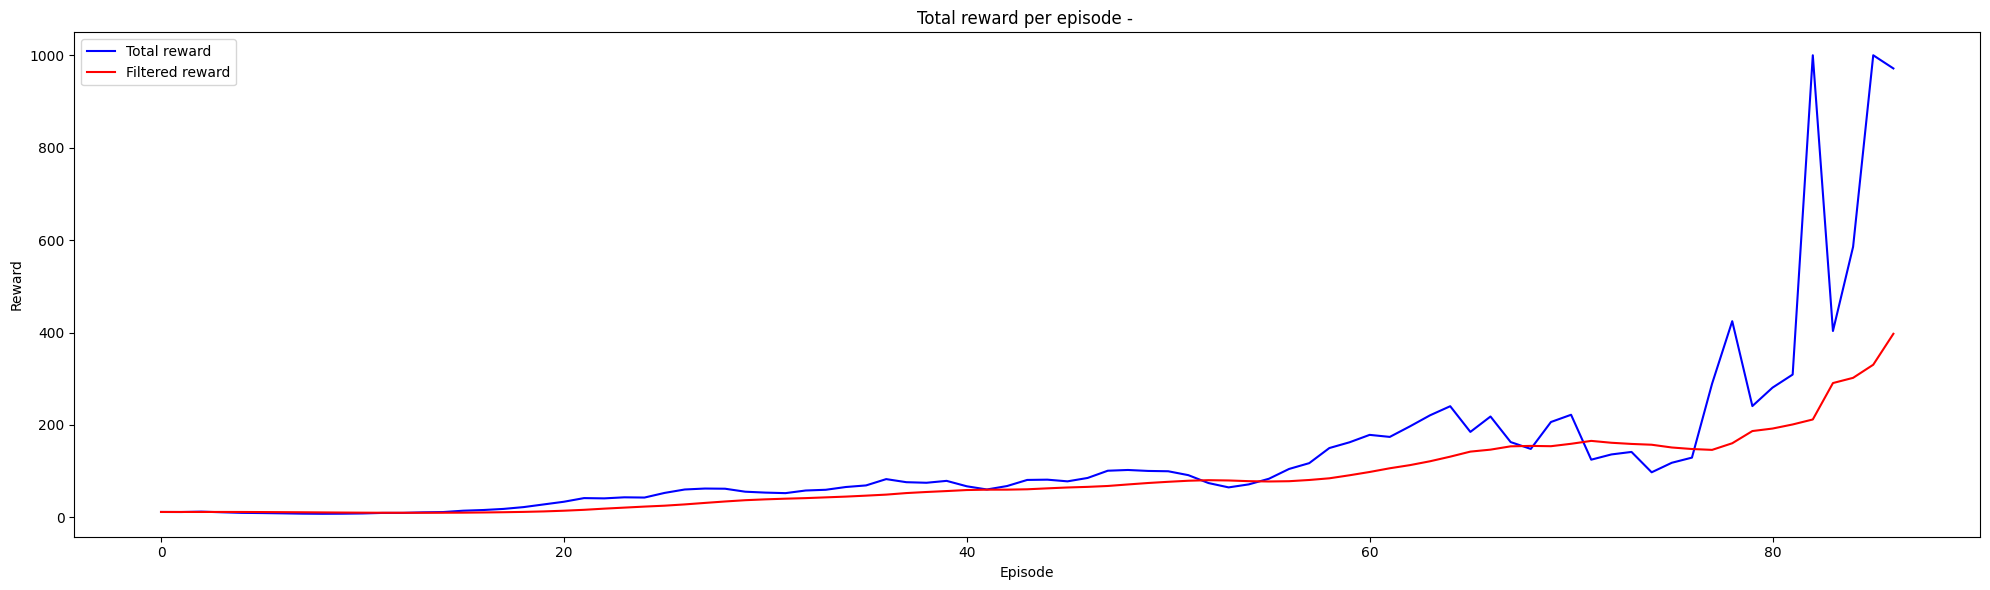

In [61]:
PPO_experiment.record()